In [4]:
import argparse
import sys, os
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/stylegan2'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/gan/'))

from gan.gan_model import cont_style_munit_enc
from models.munit.enc_dec import MunitEncoder
from parameters.dataset import DatasetParameters
from parameters.deformation import DeformationParameters
from parameters.gan import GanParameters, MunitParameters
import albumentations
from albumentations.pytorch.transforms import ToTensor as AlbToTensor
from dataset.cardio_dataset import ImageMeasureDataset
from torch.utils import data
from transforms_utils.transforms import MaskToMeasure
import numpy as np

In [58]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [50]:
from dataset.cardio_dataset import ImageMeasureDataset
from dataset.probmeasure import ProbabilityMeasure, ProbabilityMeasureFabric

In [89]:
import torch
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.set_device(device)

cuda:2


In [180]:
import random

In [183]:
def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)
    
def sample_data(loader):
    while True:
        for batch in loader:
            yield batch

def content_to_measure(content):
    batch_size = content.shape[0]
    pred_measures: ProbabilityMeasure = ProbabilityMeasure(
            torch.ones(batch_size, 70, device=device) / 70,
            content.reshape(batch_size, 70, 2)
        )
    return pred_measures

def imgs_with_mask(imgs, mask, color=[1.0,1.0,1.0]):
    # mask = torch.cat([mask, mask, mask], dim=1)
    mask = mask[:, 0, :, :]
    res: Tensor = imgs.cpu().detach()
    res = res.permute(0, 2, 3, 1)
    res[mask > 0.00001, :] = torch.tensor(color, dtype=torch.float32)
    res = res.permute(0, 3, 1, 2)

    return res

def make_noise(batch, latent_dim, n_noise, device):
    if n_noise == 1:
        return torch.randn(batch, latent_dim, device=device)

    noises = torch.randn(n_noise, batch, latent_dim, device=device).unbind(0)

    return noises

def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return [make_noise(batch, latent_dim, 1, device)]



In [189]:
class Args:
    iter = 800000
    batch = 8
    n_sample = 64
    size = 256
    r1 = 10
    path_regularize = 2
    path_batch_shrink = 2
    d_reg_every = 16
    g_reg_every = 4
    mixing = 0.9
    ckpt = None
    lr = 0.002
    channel_multiplier = 1
    wandb = 'store_true'
    local_rank = 0
    image_size = 256
    batch_size = 8
    measure_size = 70 
    ct = 0.0001
    ca = 0.0002
    cw = 0.002
    ngf = 64
    ndf = 64 
    L1 = 2
    noise_size = 256.0
    input_dim = 3 
    dim = 16
    style_dim = 512 
    n_downsample = 2
    n_res = 4 
    activ = 'lrelu'
    pad_type = 'replicate'
    norm = 'none'
    mlp_dim = 256
    n_layer = 8
    num_scales = 1
    

munit_args=Args()

In [35]:
cont_style_encoder: MunitEncoder = cont_style_munit_enc(
        munit_args,
        None, # "/home/ibespalov/pomoika/munit_content_encoder15.pt",
        None  # "/home/ibespalov/pomoika/munit_style_encoder_1.pt"
    )

In [150]:
starting_model_number = 340000 
# weights = torch.load(f"/home/ibespalov/pomoika/stylegan2_invertable_{starting_model_number}.pt", map_location="cpu")
weights = torch.load(f"/home/ibespalov/pomoika/stylegan2_igor_2.pt", map_location="cpu")
cont_style_encoder.load_state_dict(weights['enc'])
cont_style_encoder = cont_style_encoder.to(device)

In [151]:
transform = albumentations.Compose(
        [
            albumentations.Resize(munit_args.size, munit_args.size),
            albumentations.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            AlbToTensor()
        ]
    )

    # dataset = ImageFolder("/raid/data/celeba", transform=transform)

dataset = ImageMeasureDataset(
    "/raid/data/celeba",
    "/raid/data/celeba_masks",
    img_transform=transform
)

loader = data.DataLoader(
    dataset,
    batch_size=1,
    sampler=data_sampler(dataset, shuffle=False, distributed=False),
    drop_last=True,
)

In [206]:
from gan.gan_model import CondStyleDisc2Wrapper, cont_style_munit_enc, CondStyleGanModel, CondGen2
from stylegan2.model import Generator
args.latent = 512
args.n_mlp = 5

args.start_iter = 0

generator = CondGen2(Generator(
    args.size, args.latent, args.n_mlp, channel_multiplier=args.channel_multiplier
))
generator.load_state_dict(weights['g'])
generator = generator.to(device)
noise1 = mixing_noise(args.batch, args.latent, args.mixing, device)
fake1, _ = generator(images_repeated, noise1)

In [198]:
fake1.shape

torch.Size([8, 3, 256, 256])

In [191]:
content.shape

torch.Size([1, 140])

In [195]:
images_repeated = for_gen_content.repeat(8,1) 
images_repeated.shape
# images_repeated = images_repeated.view(-1,input_size, sequence_length)

torch.Size([8, 140])

In [193]:
for_gen_content = cont_style_encoder.get_content(test_img)
for_gen_content

torch.Size([1, 140])

In [200]:
fake1 = fake1[0]

In [203]:
fake1.shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


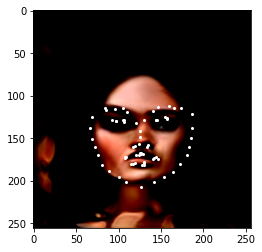

In [208]:
plt.imshow(fake1.detach().cpu().numpy()[0].transpose(1,2,0))
plt.scatter(y, x, s=4, marker='o', c='w')

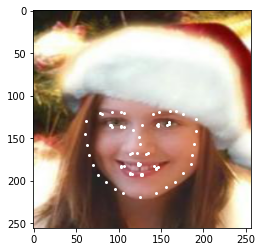

In [225]:
loader = sample_data(loader)
test_img, test_mask = next(loader)
test_img = test_img.cuda()
test_mask = test_mask.cuda()
content, latent = cont_style_encoder(test_img)
test_img = (test_img + 1) / 2
pred_measures: ProbabilityMeasure = content_to_measure(content)
x = np.around((pred_measures.coord[0,:,0] * 256).detach().cpu().numpy())
y = np.around((pred_measures.coord[0,:,1] * 256).detach().cpu().numpy())
plt.imshow(test_img.detach().cpu().numpy()[0].transpose(1,2,0))
plt.scatter(y, x, s=4, marker='o', c='w')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


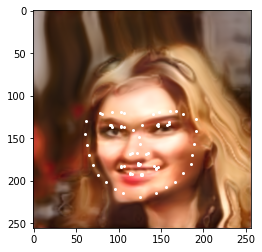

In [228]:
images_repeated = content.repeat(8,1) 
noise1 = mixing_noise(args.batch, args.latent, args.mixing, device)
fake1, _ = generator(images_repeated, noise1)
plt.imshow(((fake1.detach().cpu().numpy()[0] + 1) / 2).transpose(1,2,0))
plt.scatter(y, x, s=4, marker='o', c='w')

In [213]:
fake1[0].max()

tensor(1.1482, device='cuda:2', grad_fn=<MaxBackward1>)

In [146]:
test_img.max()

tensor(1., device='cuda:2')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


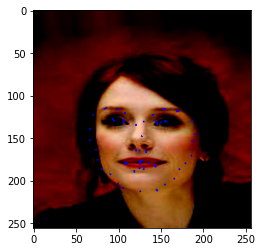

In [121]:
iwm = imgs_with_mask(test_img, pred_measures.toImage(256), color=[0, 0, 1])
iwm = iwm.numpy()[0].transpose(1,2,0)
plt.imshow(iwm)